# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
plt.rcParams['image.cmap'] = "gray"

In [2]:
from sklearn.model_selection import train_test_split


df = pd.read_excel('alldata.xlsx')
df = df.dropna()
labels = df['parti']
df = df.drop(columns=['storkreds', 'alder', 'navn', 'parti'])



from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
X_scaled= scaler.transform(df)

from sklearn.decomposition import PCA
# keep the first ten principal components of the data
pca = PCA(n_components = 10)
# fit PCA model to beast cancer data
pca.fit(X_scaled)

# transform data onto the first ten principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))


Original shape: (867, 49)
Reduced shape: (867, 10)


In [3]:
import numpy


print(f"The ratio of 10 components: {pca.explained_variance_ratio_}")
print(f"This is how much information is explained in those ten components: {numpy.sum(pca.explained_variance_ratio_)}")

The ratio of 10 components: [0.41737636 0.10259865 0.04976014 0.04300922 0.02932179 0.02370048
 0.01994227 0.01694494 0.01671247 0.01604036]
This is how much information is explained in those ten components: 0.735406686208156


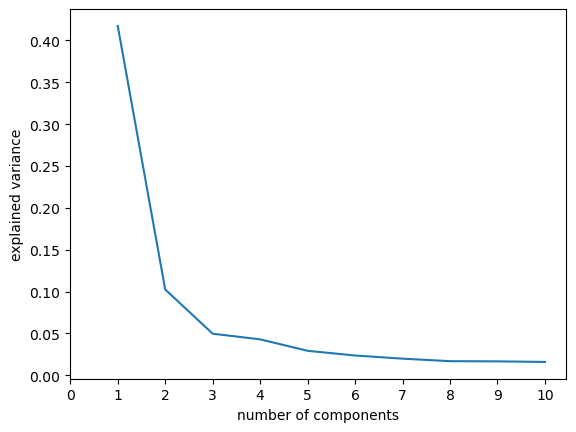

In [4]:
plt.plot(list(range(1, 1 + len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xticks(np.arange(0, 1 + len(pca.explained_variance_ratio_), step=1))
plt.show()

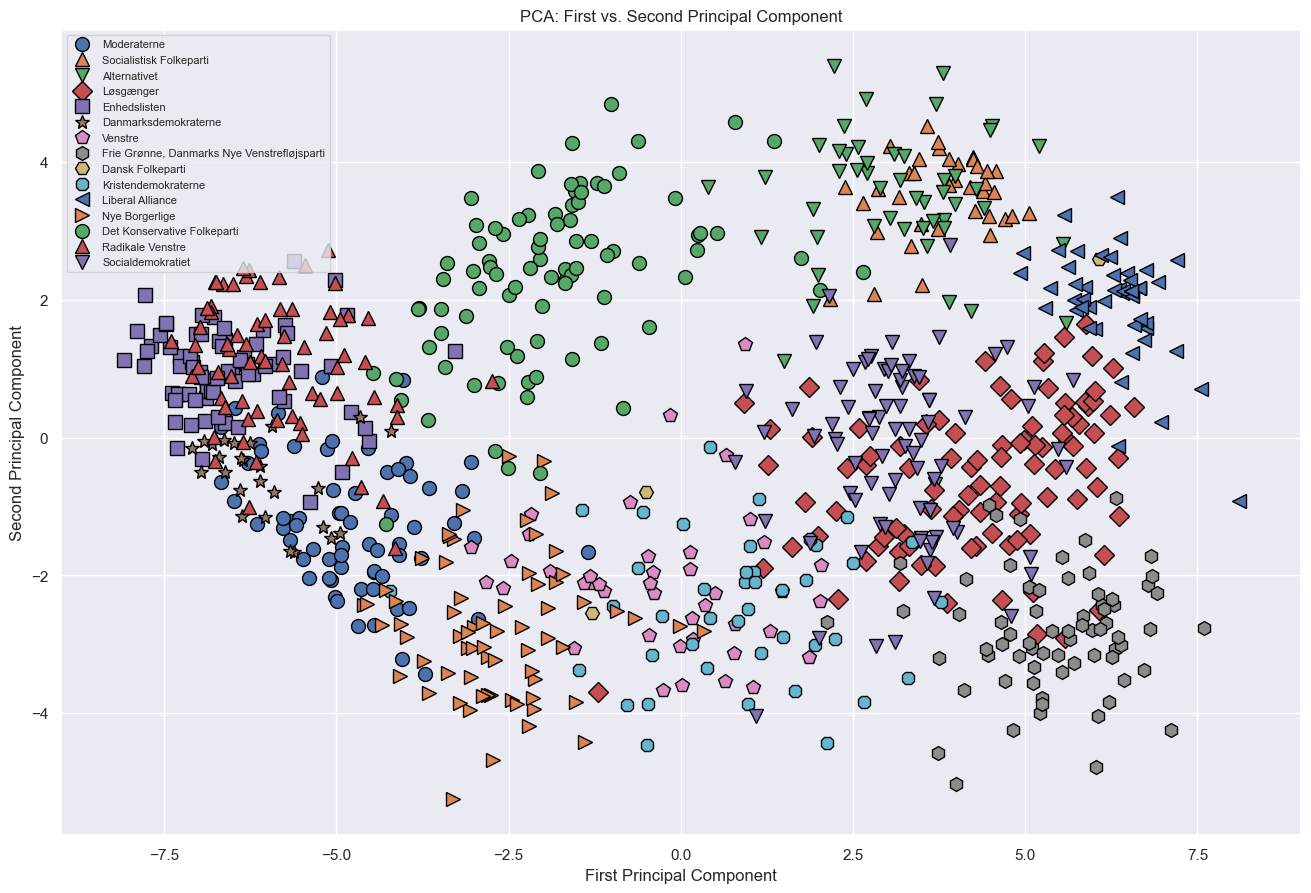

In [38]:
# # plot first vs. second principal component, colored by class
# plt.figure(figsize=(16, 16))
# mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], labels)
# plt.legend(labels.unique(), loc="best")
# plt.gca().set_aspect("equal")
# plt.xlabel("First principal component")
# plt.ylabel("Second principal component")

# Create a new figure with improved styling
plt.figure(figsize=(16, 12))

# Scatter plot with labeled points
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], labels, markeredgewidth=1)

# Add legend (smaller size and outside the graph)
plt.legend(labels.unique(), loc="upper left", fontsize=8)

# Set equal aspect ratio for better visualization
plt.gca().set_aspect("equal")

# Customize axis labels
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

# Add a title
plt.title("PCA: First vs. Second Principal Component")

# Show the grid
plt.grid(True)

# Display the plot
plt.show()

#use the loading parameter for PCA

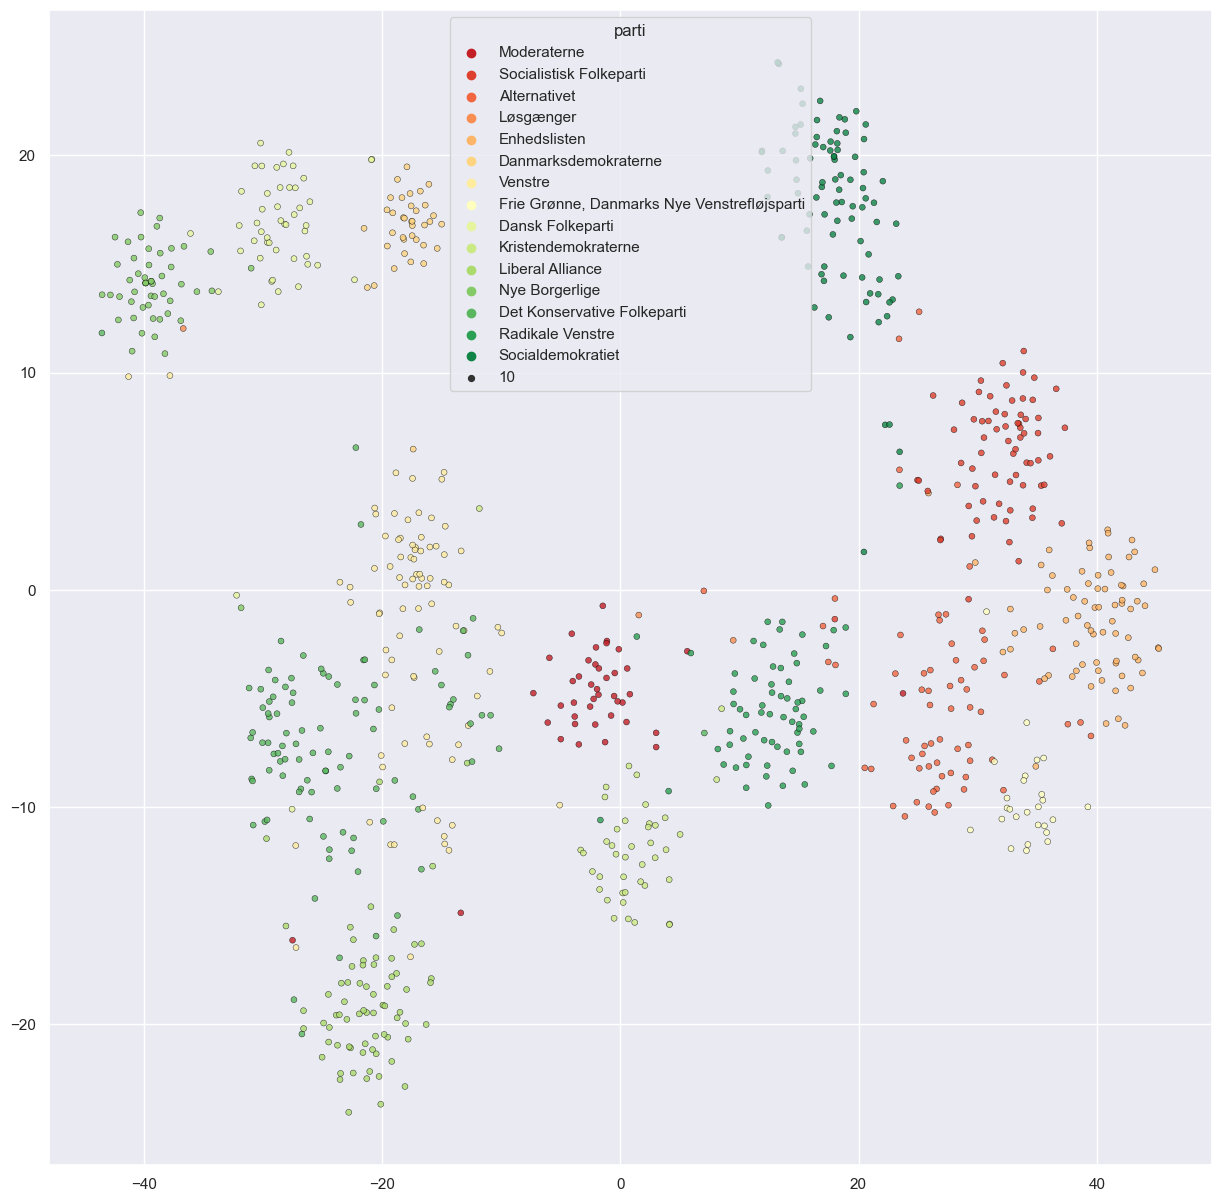

In [10]:
from matplotlib import colors
import seaborn as sns
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method
politcal_tsne = tsne.fit_transform(df)

def visualize_2d(x, labels):
    sns.set_theme(rc={'figure.figsize':(15,15)})
    sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, palette='RdYlGn', s=100, alpha=0.8, edgecolor="black", size=10)
    
visualize_2d(politcal_tsne, labels)

Lets's take a look at the disagreements within the elected canidates. For that I will reuse the method from the first assignment on the canidates. This method calculates the distances between each candidate.

In [14]:
elected_df = pd.read_excel('electeddata.xlsx')
data_only_questions_and_parti = elected_df.drop(['navn', 'alder', 'storkreds'], axis=1)
data3 = data_only_questions_and_parti.drop(['parti'], axis=1)

total_differences = []

# This function calculates differences between each of the candidates (1st to 2nd, 1st to 3rd... etc.)           
def differenceCalculator(data):
    n = len(data)
    # Pre-calculate properties to avoid repeated function calls
    properties = {'navn': elected_df['navn'], 'parti': elected_df['parti']}
    
    for i in range(n):
        person1 = data.iloc[i]
        name1, party1 = properties['navn'][i], properties['parti'][i]
        for j in range(i + 1, n):
            person2 = data.iloc[j]
            name2, party2 = properties['navn'][j], properties['parti'][j]
            # In this line we subtract each question and then sum those differences
            # absoluteValue of (-1-2) = 3 and so on... (don't agree - strongly agree)
            difference = abs(person1 - person2).sum() 
            total_differences.append((i, j, name1, name2, party1, party2, difference))
    return total_differences

differenceCalculator(data3)

# Convert the list of differences to DataFrame
differences_df = pd.DataFrame(total_differences, columns=['id1', 'id2','candidate1','candidate2', 'parti1', 'parti2', 'totalDifference'])


Okay, now let's consider the interparty disagreements.

In [19]:
differences_df.sort_values(by='totalDifference', ascending=False).head(10)

,id1,id2,candidate1,candidate2,parti1,parti2,totalDifference
6651,45,127,Peder Hvelplund,Sandra Elisabeth Skalvig,Enhedslisten,Liberal Alliance,141
5356,35,107,Ole Birk Olesen,Karina Lorentzen Dehnhardt,Liberal Alliance,Socialistisk Folkeparti,140
6669,45,145,Peder Hvelplund,Steffen Frølund,Enhedslisten,Liberal Alliance,140
6630,45,106,Peder Hvelplund,Henrik Dahl,Enhedslisten,Liberal Alliance,140
2434,15,35,Charlotte Broman Mølbæk,Ole Birk Olesen,Socialistisk Folkeparti,Liberal Alliance,139
12324,107,127,Karina Lorentzen Dehnhardt,Sandra Elisabeth Skalvig,Socialistisk Folkeparti,Liberal Alliance,139
6684,45,160,Peder Hvelplund,Steffen Larsen,Enhedslisten,Liberal Alliance,139
6633,45,109,Peder Hvelplund,Niels Flemming Hansen,Enhedslisten,Det Konservative Folkeparti,138
6598,45,74,Peder Hvelplund,Mai Mercado,Enhedslisten,Det Konservative Folkeparti,138
5294,35,45,Ole Birk Olesen,Peder Hvelplund,Liberal Alliance,Enhedslisten,138


Peter Hvelplund seems to be a pearson that is the most disagreed with. This is also no surprise that the most conservative left wing party has a lot of dissagreements with right wing parties.

How about internal disagreements?

In [22]:
diff_intra = differences_df[differences_df['parti1'] == differences_df['parti2']]
display(diff_intra.sort_values(by='totalDifference', ascending=False).head(10)) 

,id1,id2,candidate1,candidate2,parti1,parti2,totalDifference
6355,43,78,Mette Reissmann,Bjørn Brandenborg,Socialdemokratiet,Socialdemokratiet,77
5063,33,81,Jon Læssøe Stephensen,Jeppe Søe,Moderaterne,Moderaterne,70
6430,43,153,Mette Reissmann,Fie Thorsted Hækkerup,Socialdemokratiet,Socialdemokratiet,70
6410,43,133,Mette Reissmann,Frederik Vad,Socialdemokratiet,Socialdemokratiet,69
12839,116,138,Benny Engelbrecht,Mette Gjerskov,Socialdemokratiet,Socialdemokratiet,69
6338,43,61,Mette Reissmann,Simon Kollerup,Socialdemokratiet,Socialdemokratiet,68
5086,33,104,Jon Læssøe Stephensen,Henrik Frandsen,Moderaterne,Moderaterne,68
5107,33,125,Jon Læssøe Stephensen,Charlotte Bagge Hansen,Moderaterne,Moderaterne,67
12867,116,166,Benny Engelbrecht,Maria Durhuus,Socialdemokratiet,Socialdemokratiet,67
6517,44,116,Ida Margrete Meier Auken,Benny Engelbrecht,Socialdemokratiet,Socialdemokratiet,67


Metter Reissmann from Socialdemokratiet has a lot of dissagrements with various colleagues from her party. This is also the case for Jon Laessoee Stephensen in Moderaterne. Those two parties seems to have high degree of internal disagreements.

What about the candidates from different parties that agree the most?

In [18]:
diff_inter = differences_df[differences_df['parti1'] != differences_df['parti2']]
display(diff_inter.sort_values(by='totalDifference', ascending=True).head(10)) 

,id1,id2,candidate1,candidate2,parti1,parti2,totalDifference
211,1,45,Torsten Gejl,Peder Hvelplund,Alternativet,Enhedslisten,15
4473,29,37,Pelle Dragsted,Carl Valentin,Enhedslisten,Socialistisk Folkeparti,19
44,0,45,Karsten Hønge,Peder Hvelplund,Socialistisk Folkeparti,Enhedslisten,19
5760,38,118,Lisbeth Bech-Nielsen,Trine Pertou Mach,Socialistisk Folkeparti,Enhedslisten,19
1,0,2,Karsten Hønge,Mai Villadsen,Socialistisk Folkeparti,Enhedslisten,19
369,2,37,Mai Villadsen,Carl Valentin,Enhedslisten,Socialistisk Folkeparti,20
493,2,161,Mai Villadsen,Sigurd Agersnap,Enhedslisten,Socialistisk Folkeparti,20
346,2,14,Mai Villadsen,Sofie Lippert,Enhedslisten,Socialistisk Folkeparti,20
370,2,38,Mai Villadsen,Lisbeth Bech-Nielsen,Enhedslisten,Socialistisk Folkeparti,20
94,0,95,Karsten Hønge,Søren Egge Rasmussen,Socialistisk Folkeparti,Enhedslisten,20


The left wing parties have the most in common, in particular Enhedslisten and Socialist Folkeparti. Mai Villadsen is a person that agrees with 5 candidates from Socialistisk Folkeparti. That could suggest that she might be in that party instead.

And finally how about the highest degree of internal agreements?

In [27]:
differences_df.sort_values(by='totalDifference', ascending=True).head(10)

,id1,id2,candidate1,candidate2,parti1,parti2,totalDifference
8924,65,150,Lea Wermelin,Rasmus Stoklund,Socialdemokratiet,Socialdemokratiet,1
12387,108,130,Pernille Vermund,Peter Seier Christensen,Nye Borgerlige,Nye Borgerlige,1
7829,55,130,Kim Edberg,Peter Seier Christensen,Nye Borgerlige,Nye Borgerlige,2
10349,80,150,Trine Bramsen,Rasmus Stoklund,Socialdemokratiet,Socialdemokratiet,2
7807,55,108,Kim Edberg,Pernille Vermund,Nye Borgerlige,Nye Borgerlige,3
8854,65,80,Lea Wermelin,Trine Bramsen,Socialdemokratiet,Socialdemokratiet,3
1142,6,156,Jakob Ellemann-Jensen,Karen Ellemann,Venstre,Venstre,3
13858,142,156,Sophie Løhde,Karen Ellemann,Venstre,Venstre,4
10848,86,142,Thomas Danielsen,Sophie Løhde,Venstre,Venstre,5
10862,86,156,Thomas Danielsen,Karen Ellemann,Venstre,Venstre,5


Those three parties seems to have the least internal disagreements. To get better understanding let's count a ratio of the number of canidadates that have less than 10 in total differnce divided by the total number of memberes of Folketing of that party.

In [ ]:
diff_inter = differences_df[differences_df['parti1'] == differences_df['parti2']]
def calculateInternalAgreements(difference):
    for party in elected_df['parti'].unique():
        countMembers = elected_df[elected_df['parti'] == party].count()
        for members in 